**Import libraries and select file**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial.transform import Rotation as R
from scipy.signal import find_peaks, peak_prominences

# read the csv file
dir = 'TestDATA/'
name = 'Noor-L'
registration = 'data.csv'
snapshot = 'snapshot.csv'

df = pd.read_csv(os.path.join(dir, name+registration))
df_snapshot = pd.read_csv(os.path.join(dir, name+snapshot))

**Convert Quaternions to Euler Angles**

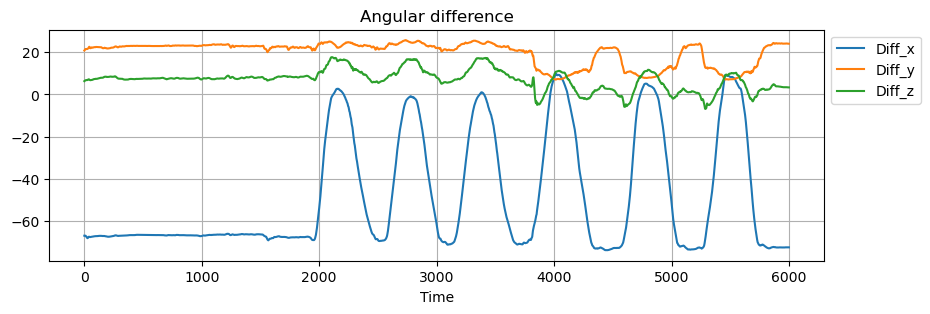

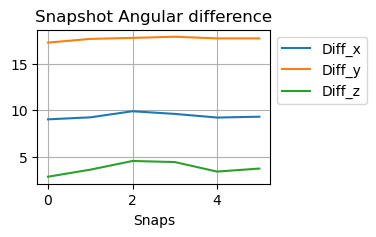

In [26]:
quat_data = []
Plot_euler_sensor_1 = []
Plot_euler_sensor_2 = []
Diff_plot = []
Diff_plot_inv = []
timing = []
euler_sequence = 'xyz'

def quaternion_to_euler1(q1):
    r = R.from_quat(q1)
    return r.as_euler(euler_sequence, degrees=True)

def quaternion_to_euler2(q2):
    r = R.from_quat(q2)
    return r.as_euler(euler_sequence, degrees=True)

def calculate_angular_difference(q1, q2):
    r1 = R.from_quat(q1)
    r2 = R.from_quat(q2)
    r = r1 * r2.inv()  # tibia relative to femur
    return r.as_euler(euler_sequence, degrees=True)

def calculate_angular_difference_inv(q1, q2):
    r1 = R.from_quat(q1)
    r2 = R.from_quat(q2)
    r = r2 * r1.inv()  # femur relative to tibia
    return r.as_euler(euler_sequence, degrees=True)

def interate_cvs(sequence):
    global euler_sequence, dataout_rows
    euler_sequence = sequence
    dataout_rows = []
    timestamp = 0

    for _, row in df.iterrows():
        w1 = float(row['w1'])
        x1 = float(row['x1'])
        y1 = float(row['y1'])
        z1 = float(row['z1'])
        w2 = float(row['w2'])
        x2 = float(row['x2'])
        y2 = float(row['y2'])
        z2 = float(row['z2'])
        q1 = w1, x1, y1, z1
        q2 = w2, x2, y2, z2

        Sensor1 = quaternion_to_euler1(q1)
        Sensor2 = quaternion_to_euler2(q2)
        diff = calculate_angular_difference(q1, q2)
        diff_inv = calculate_angular_difference_inv(q1, q2)
        timestamp += 1
        dataout_row = {
            'timestamp': timestamp,
            'Sensor1_x': Sensor1[0],
            'Sensor1_y': Sensor1[1],
            'Sensor1_z': Sensor1[2],
            'Sensor2_x': Sensor2[0],
            'Sensor2_y': Sensor2[1],
            'Sensor2_z': Sensor2[2],
            'Diff_x': diff[0],
            'Diff_y': diff[1],
            'Diff_z': diff[2],
            'Diff_inv_x': diff_inv[0],
            'Diff_inv_y': diff_inv[1],
            'Diff_inv_z': diff_inv[2]
        }
        dataout_rows.append(dataout_row)

interate_cvs('xyz')

# Create a new DataFrame from the list
converted_data = pd.DataFrame(dataout_rows)

def interate_snapshot_cvs(sequence):
    global euler_sequence, snapshot_rows
    euler_sequence = sequence
    snapshot_rows = []
    timestamp = 0

    for _, row in df_snapshot.iterrows():
        w1 = float(row['w1'])
        x1 = float(row['x1'])
        y1 = float(row['y1'])
        z1 = float(row['z1'])
        w2 = float(row['w2'])
        x2 = float(row['x2'])
        y2 = float(row['y2'])
        z2 = float(row['z2'])
        q1 = w1, x1, y1, z1
        q2 = w2, x2, y2, z2

        Sensor1 = quaternion_to_euler1(q1)
        Sensor2 = quaternion_to_euler2(q2)
        diff = calculate_angular_difference(q1, q2)
        diff_inv = calculate_angular_difference_inv(q1, q2)
        timestamp += 1
        snapshot_row = {
            'timestamp': timestamp,
            'Sensor1_x': Sensor1[0],
            'Sensor1_y': Sensor1[1],
            'Sensor1_z': Sensor1[2],
            'Sensor2_x': Sensor2[0],
            'Sensor2_y': Sensor2[1],
            'Sensor2_z': Sensor2[2],
            'Diff_x': diff[0],
            'Diff_y': diff[1],
            'Diff_z': diff[2],
            'Diff_inv_x': diff_inv[0],
            'Diff_inv_y': diff_inv[1],
            'Diff_inv_z': diff_inv[2]
        }
        snapshot_rows.append(snapshot_row)

interate_snapshot_cvs('xyz')

# Create a new DataFrame from the list
converted_snapshot = pd.DataFrame(snapshot_rows)

# Create a copy of 'Diff_x' and rename it to 'Diff_x_copy'
converted_data['Degrees_x'] = converted_data['Diff_x'].copy()

plt.figure(figsize=(10, 3))
converted_data['Diff_x'].plot()
converted_data['Diff_y'].plot()
converted_data['Diff_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Angular difference')
plt.xlabel('Time')
plt.show()

plt.figure(figsize=(3, 2))
converted_snapshot['Diff_x'].plot()
converted_snapshot['Diff_y'].plot()
converted_snapshot['Diff_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Snapshot Angular difference')
plt.xlabel('Snaps')
plt.show()

**Adjust data for baseline (calibrate)**

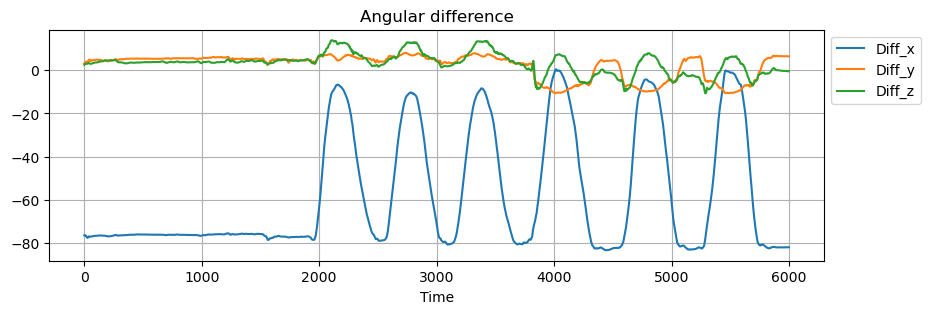

In [27]:
# Calculate the mean of all columns in snapshot
extension_baseline = converted_snapshot.mean()

# Subtract the mean of all columns in snapshot from all columns in dataout
converted_data['Diff_x'] = converted_data['Diff_x'] - extension_baseline['Diff_x']
converted_data['Diff_y'] = converted_data['Diff_y'] - extension_baseline['Diff_y']
converted_data['Diff_z'] = converted_data['Diff_z'] - extension_baseline['Diff_z']
converted_data['Degrees_x'] = converted_data['Degrees_x'] - extension_baseline['Diff_x']

calibrated_data = converted_data

flexion_baseline = calibrated_data

# plot dataout
plt.figure(figsize=(10, 3))
calibrated_data['Diff_x'].plot()
calibrated_data['Diff_y'].plot()
calibrated_data['Diff_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Angular difference')
plt.xlabel('Time')
plt.show()


**Drop begin and end**

**Find Peaks and Valleys**

Check Graph!

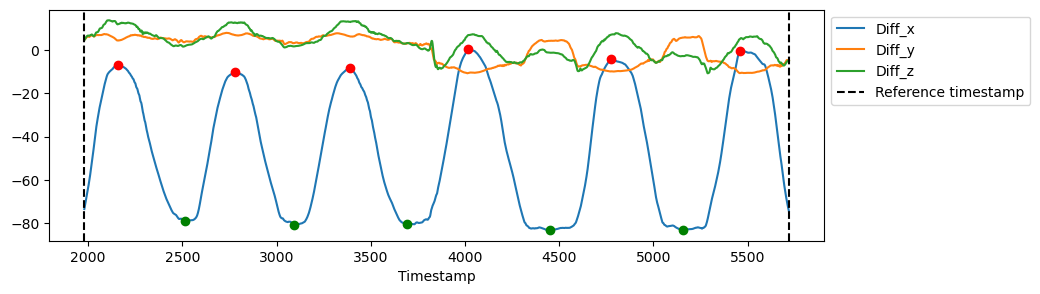

In [28]:
# Calculate the derivative of Diff_x
degrees_x_derivative = np.gradient(calibrated_data['Degrees_x'])

# Set a threshold for detecting rapid changes
threshold = 0.4  # You may need to adjust this threshold based on your data

# Find the indices where the derivative exceeds the threshold for the first time for both increase and decrease
rapid_increase_index = np.argmax(degrees_x_derivative > threshold)
rapid_decrease_index = np.argmax(degrees_x_derivative < -threshold)

# Get the timestamp at the rapid increase and decrease points
rapid_increase_timestamp = calibrated_data['timestamp'].iloc[rapid_increase_index]
rapid_decrease_timestamp = calibrated_data['timestamp'].iloc[rapid_decrease_index]

# Determine the reference timestamp
reference_timestamp = min(rapid_increase_timestamp, rapid_decrease_timestamp)

# Create a new DataFrame by filtering rows based on the reference timestamp
calibrated_data = calibrated_data[calibrated_data['timestamp'] >= reference_timestamp].copy()

# Reset index
calibrated_data.reset_index(drop=True, inplace=True)

# Calculate the derivative of Diff_x
degrees_x_derivative = np.gradient(calibrated_data['Degrees_x'])

# Reverse the DataFrame after filtering based on the initial rapid change point
dataout_reverse = calibrated_data[::-1].copy()

# Calculate the derivative of Diff_x for the reversed DataFrame
degrees_x_derivative_reverse = np.gradient(dataout_reverse['Degrees_x'])

# Find the index where the reversed derivative exceeds the threshold for the first time
rapid_change_index_reverse = np.argmax(np.abs(degrees_x_derivative_reverse) > threshold)

# Get the timestamp at the rapid change point from the end
rapid_change_timestamp_reverse = dataout_reverse['timestamp'].iloc[rapid_change_index_reverse]

# Drop rows after rapid_change_timestamp_reverse
calibrated_data = calibrated_data[calibrated_data['timestamp'] <= rapid_change_timestamp_reverse].copy()

# Reset index
calibrated_data.reset_index(drop=True, inplace=True)


dropped_calibrated_data = calibrated_data

# Find peaks
peaks, _ = find_peaks(dropped_calibrated_data['Degrees_x'], distance=20)  
# Find valleys
valleys, _ = find_peaks(-dropped_calibrated_data['Degrees_x'], distance=20) 
# Compute prominences of peaks
prominences_peaks = peak_prominences(dropped_calibrated_data['Degrees_x'], peaks)[0]
# Filter peaks based on prominence
filtered_peaks = peaks[prominences_peaks > 60]
# Compute prominences of valleys
prominences_valleys = peak_prominences(-dropped_calibrated_data['Degrees_x'], valleys)[0]
# Filter valleys based on prominence
filtered_valleys = valleys[prominences_valleys > 60]
# find timestamp of filtered peaks
filtered_peaks_timestamp = dropped_calibrated_data['timestamp'].iloc[filtered_peaks]
# find timestamp of filtered valleys
filtered_valleys_timestamp = dropped_calibrated_data['timestamp'].iloc[filtered_valleys]

# print("Filtered peaks:", filtered_peaks)
# print("Timestamp of filtered peaks:", filtered_peaks_timestamp)
# print("Filtered valleys:", filtered_valleys)
# print("Timestamp of filtered valleys:", filtered_valleys_timestamp)


# plot dataout 'Diff_x', 'Diff_y', 'Diff_z'
plt.figure(figsize=(10, 3))
plt.plot(dropped_calibrated_data['timestamp'], dropped_calibrated_data['Diff_x'], label='Diff_x')
plt.plot(dropped_calibrated_data['timestamp'], dropped_calibrated_data['Diff_y'], label='Diff_y')
plt.plot(dropped_calibrated_data['timestamp'], dropped_calibrated_data['Diff_z'], label='Diff_z')

# plot rapid change timestamps
plt.axvline(x=reference_timestamp, color='black', linestyle='--', label='Reference timestamp')
plt.axvline(x=rapid_change_timestamp_reverse, color='black', linestyle='--')

# plot filtered peaks
plt.plot(filtered_peaks_timestamp, dropped_calibrated_data['Diff_x'].iloc[filtered_peaks], "o", color='red')

# plot filtered valleys
plt.plot(filtered_valleys_timestamp, dropped_calibrated_data['Diff_x'].iloc[filtered_valleys], "o", color='green')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Timestamp')
plt.show()



**Cut cycles and 'normalize' data to degrees instead of time**

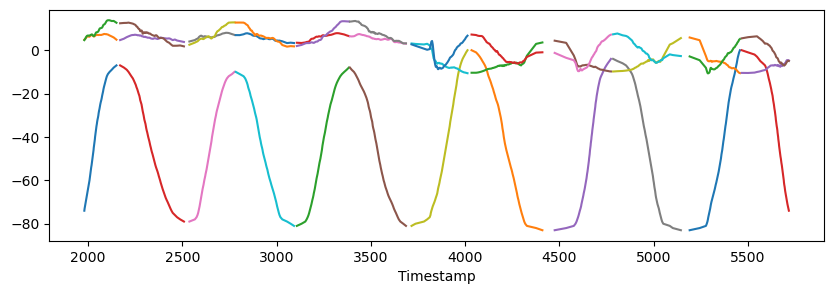

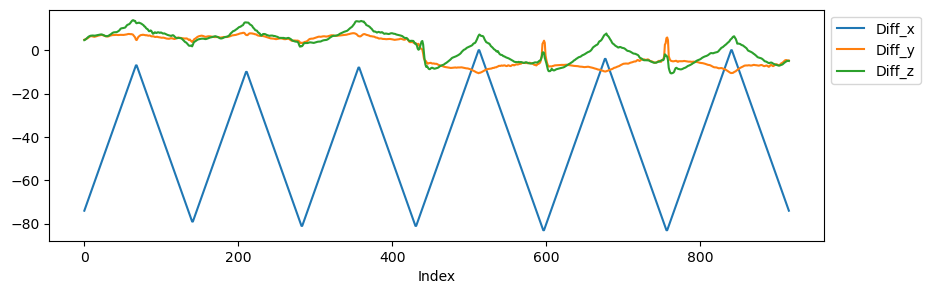

In [29]:
cut_dataframes = []

# Initialize start index as 0
start_index = 0

# Determine whether the data starts with a peak or a valley
if filtered_peaks[0] < filtered_valleys[0]:
    peak_first = True
else:
    peak_first = False

# Iterate through peaks and valleys
for peak_index, valley_index in zip(filtered_peaks, filtered_valleys):
    # Slice the dataframe from start_index to peak_index or valley_index depending on the peak_first condition
    if peak_first:
        first_cut = dropped_calibrated_data.iloc[start_index:peak_index+1].copy()
        cut_dataframes.append(first_cut)
    else:
        first_cut = dropped_calibrated_data.iloc[start_index:valley_index+1].copy()
        cut_dataframes.append(first_cut)
    
    # Slice the dataframe from peak_index to valley_index or valley_index to peak_index depending on the peak_first condition
    if peak_first:
        second_cut = dropped_calibrated_data.iloc[peak_index:valley_index+1].copy()
        cut_dataframes.append(second_cut)
    else:
        second_cut = dropped_calibrated_data.iloc[valley_index:peak_index+1].copy()
        cut_dataframes.append(second_cut)
    
    # Update start_index for the next iteration
    if peak_first:
        start_index = valley_index
    else:
        start_index = peak_index

if peak_first:
        # Check if there are remaining peaks after the last valley
    if filtered_peaks[-1] > filtered_valleys[-1]:
        # Include the remaining data from the last valley to the last peak
        last_valley_index = filtered_valleys[-1]
        last_peak_index = filtered_peaks[-1]
        last_cut = dropped_calibrated_data.iloc[last_valley_index:last_peak_index+1].copy()
        cut_dataframes.append(last_cut)

    # Include the data after the last peak if it's the case
    if last_peak_index < len(dropped_calibrated_data):
        remaining_data = dropped_calibrated_data.iloc[last_peak_index:].copy()
        cut_dataframes.append(remaining_data)

else:
    # Check if there are remaining valleys after the last peak
    if filtered_valleys[-1] > filtered_peaks[-1]:
        # Include the remaining data from the last peak to the last valley
        last_peak_index = filtered_peaks[-1]
        last_valley_index = filtered_valleys[-1]
        last_cut = dropped_calibrated_data.iloc[last_peak_index:last_valley_index+1].copy()
        cut_dataframes.append(last_cut)

    # Include the data after the last valley if it's the case
    if last_valley_index < len(dropped_calibrated_data):
        remaining_data = dropped_calibrated_data.iloc[last_valley_index:].copy()
        cut_dataframes.append(remaining_data)

# Loop through each dataframe in cut_dataframes
for df_cut in cut_dataframes:
    # Round the Diff_x values in each dataframe
    df_cut['Degrees_x'] = df_cut['Degrees_x'].round()
    df_cut['Diff_x'] = df_cut['Diff_x'].round()
    df_cut['Diff_inv_x'] = df_cut['Diff_inv_x'].round()

# Create a list to store the averaged dataframes
averaged_dfs = []

# Loop through each dataframe in cut_dataframes
for df_cut in cut_dataframes:
    # Group by the 'Degrees_x' column and calculate the average for each group
    averaged_df = df_cut.groupby('Degrees_x', sort=False).mean().reset_index()
    averaged_dfs.append(averaged_df)

plt.figure(figsize=(10, 3))
# Plot the averaged dataframes
for i, df_avg in enumerate(averaged_dfs):
    plt.plot(df_avg['timestamp'], df_avg['Diff_x'], label=f"Averaged DataFrame {i+1}")
    plt.plot(df_avg['timestamp'], df_avg['Diff_y'], label=f"Averaged DataFrame {i+1}")
    plt.plot(df_avg['timestamp'], df_avg['Diff_z'], label=f"Averaged DataFrame {i+1}")

plt.xlabel('Timestamp')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Concatenate the averaged dataframes
degree_data = pd.concat(averaged_dfs, ignore_index=True)

# Plot the concatenated averaged dataframes
plt.figure(figsize=(10, 3))
plt.plot(degree_data.index, degree_data['Diff_x'], label='Diff_x')
plt.plot(degree_data.index, degree_data['Diff_y'], label='Diff_y')
plt.plot(degree_data.index, degree_data['Diff_z'], label='Diff_z')
plt.xlabel('Index')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


**Calculate average cycle for the 3 Open and Closed Kinetic Chain cycles**

In [30]:
# Define the range for extention
if peak_first:
    extension_range = np.arange(-120, 21)
else:
    extension_range = np.arange(120, -21, -1)
    

columns = ['Degrees_x']
# Create an empty dataframe with the specified index and columns
extension_df = pd.DataFrame(index=extension_range, columns=columns)

extension_df['Degrees_x'] = extension_df.index


# Define the range for flexion

if peak_first:
    flexion_range = np.arange(20, -121, -1)  # Ensure you generate the range in descending order
else:
    flexion_range = np.arange(-20, 121)

columns = ['Degrees_x']
# Create an empty dataframe with the specified index and columns
flexion_df = pd.DataFrame(index=flexion_range, columns=columns)

flexion_df['Degrees_x'] = flexion_df.index

OKC_extension_df = pd.merge(extension_df, averaged_dfs[0], on='Degrees_x', how='left')
OKC_extension_df = pd.merge(OKC_extension_df, averaged_dfs[2], on='Degrees_x', how='left', suffixes=('', '_2'))
OKC_extension_df = pd.merge(OKC_extension_df, averaged_dfs[4], on='Degrees_x', how='left', suffixes=('', '_4'))

OKC_flexion_df = pd.merge(flexion_df, averaged_dfs[1], on='Degrees_x', how='left')
OKC_flexion_df = pd.merge(OKC_flexion_df, averaged_dfs[3], on='Degrees_x', how='left', suffixes=('', '_2'))
OKC_flexion_df = pd.merge(OKC_flexion_df, averaged_dfs[5], on='Degrees_x', how='left', suffixes=('', '_4'))

CKC_extension_df = pd.merge(extension_df, averaged_dfs[6], on='Degrees_x', how='left')
CKC_extension_df = pd.merge(CKC_extension_df, averaged_dfs[8], on='Degrees_x', how='left', suffixes=('', '_2'))
CKC_extension_df = pd.merge(CKC_extension_df, averaged_dfs[10], on='Degrees_x', how='left', suffixes=('', '_4'))

CKC_flexion_df = pd.merge(flexion_df, averaged_dfs[7], on='Degrees_x', how='left')
CKC_flexion_df = pd.merge(CKC_flexion_df, averaged_dfs[9], on='Degrees_x', how='left', suffixes=('', '_2'))
CKC_flexion_df = pd.merge(CKC_flexion_df, averaged_dfs[11], on='Degrees_x', how='left', suffixes=('', '_4'))


# Calculate the average
OKC_extension_df['timestamp_avg'] = OKC_extension_df[['timestamp', 'timestamp_2', 'timestamp_4']].mean(axis=1)
OKC_extension_df['Sensor1_x_avg'] = OKC_extension_df[['Sensor1_x', 'Sensor1_x_2', 'Sensor1_x_4']].mean(axis=1)
OKC_extension_df['Sensor1_y_avg'] = OKC_extension_df[['Sensor1_y', 'Sensor1_y_2', 'Sensor1_y_4']].mean(axis=1)
OKC_extension_df['Sensor1_z_avg'] = OKC_extension_df[['Sensor1_z', 'Sensor1_z_2', 'Sensor1_z_4']].mean(axis=1)
OKC_extension_df['Sensor2_x_avg'] = OKC_extension_df[['Sensor2_x', 'Sensor2_x_2', 'Sensor2_x_4']].mean(axis=1)
OKC_extension_df['Sensor2_y_avg'] = OKC_extension_df[['Sensor2_y', 'Sensor2_y_2', 'Sensor2_y_4']].mean(axis=1)
OKC_extension_df['Sensor2_z_avg'] = OKC_extension_df[['Sensor2_z', 'Sensor2_z_2', 'Sensor2_z_4']].mean(axis=1)
OKC_extension_df['Diff_x_avg'] = OKC_extension_df[['Diff_x', 'Diff_x_2', 'Diff_x_4']].mean(axis=1)
OKC_extension_df['Diff_y_avg'] = OKC_extension_df[['Diff_y', 'Diff_y_2', 'Diff_y_4']].mean(axis=1)
OKC_extension_df['Diff_z_avg'] = OKC_extension_df[['Diff_z', 'Diff_z_2', 'Diff_z_4']].mean(axis=1)
OKC_extension_df['Diff_inv_x_avg'] = OKC_extension_df[['Diff_inv_x', 'Diff_inv_x_2', 'Diff_inv_x_4']].mean(axis=1)
OKC_extension_df['Diff_inv_y_avg'] = OKC_extension_df[['Diff_inv_y', 'Diff_inv_y_2', 'Diff_inv_y_4']].mean(axis=1)
OKC_extension_df['Diff_inv_z_avg'] = OKC_extension_df[['Diff_inv_z', 'Diff_inv_z_2', 'Diff_inv_z_4']].mean(axis=1)

OKC_flexion_df['timestamp_avg'] = OKC_flexion_df[['timestamp', 'timestamp_2', 'timestamp_4']].mean(axis=1)
OKC_flexion_df['Sensor1_x_avg'] = OKC_flexion_df[['Sensor1_x', 'Sensor1_x_2', 'Sensor1_x_4']].mean(axis=1)
OKC_flexion_df['Sensor1_y_avg'] = OKC_flexion_df[['Sensor1_y', 'Sensor1_y_2', 'Sensor1_y_4']].mean(axis=1)
OKC_flexion_df['Sensor1_z_avg'] = OKC_flexion_df[['Sensor1_z', 'Sensor1_z_2', 'Sensor1_z_4']].mean(axis=1)
OKC_flexion_df['Sensor2_x_avg'] = OKC_flexion_df[['Sensor2_x', 'Sensor2_x_2', 'Sensor2_x_4']].mean(axis=1)
OKC_flexion_df['Sensor2_y_avg'] = OKC_flexion_df[['Sensor2_y', 'Sensor2_y_2', 'Sensor2_y_4']].mean(axis=1)
OKC_flexion_df['Sensor2_z_avg'] = OKC_flexion_df[['Sensor2_z', 'Sensor2_z_2', 'Sensor2_z_4']].mean(axis=1)
OKC_flexion_df['Diff_x_avg'] = OKC_flexion_df[['Diff_x', 'Diff_x_2', 'Diff_x_4']].mean(axis=1)
OKC_flexion_df['Diff_y_avg'] = OKC_flexion_df[['Diff_y', 'Diff_y_2', 'Diff_y_4']].mean(axis=1)
OKC_flexion_df['Diff_z_avg'] = OKC_flexion_df[['Diff_z', 'Diff_z_2', 'Diff_z_4']].mean(axis=1)
OKC_flexion_df['Diff_inv_x_avg'] = OKC_flexion_df[['Diff_inv_x', 'Diff_inv_x_2', 'Diff_inv_x_4']].mean(axis=1)
OKC_flexion_df['Diff_inv_y_avg'] = OKC_flexion_df[['Diff_inv_y', 'Diff_inv_y_2', 'Diff_inv_y_4']].mean(axis=1)
OKC_flexion_df['Diff_inv_z_avg'] = OKC_flexion_df[['Diff_inv_z', 'Diff_inv_z_2', 'Diff_inv_z_4']].mean(axis=1)

CKC_extension_df['timestamp_avg'] = CKC_extension_df[['timestamp', 'timestamp_2', 'timestamp_4']].mean(axis=1)
CKC_extension_df['Sensor1_x_avg'] = CKC_extension_df[['Sensor1_x', 'Sensor1_x_2', 'Sensor1_x_4']].mean(axis=1)
CKC_extension_df['Sensor1_y_avg'] = CKC_extension_df[['Sensor1_y', 'Sensor1_y_2', 'Sensor1_y_4']].mean(axis=1)
CKC_extension_df['Sensor1_z_avg'] = CKC_extension_df[['Sensor1_z', 'Sensor1_z_2', 'Sensor1_z_4']].mean(axis=1)
CKC_extension_df['Sensor2_x_avg'] = CKC_extension_df[['Sensor2_x', 'Sensor2_x_2', 'Sensor2_x_4']].mean(axis=1)
CKC_extension_df['Sensor2_y_avg'] = CKC_extension_df[['Sensor2_y', 'Sensor2_y_2', 'Sensor2_y_4']].mean(axis=1)
CKC_extension_df['Sensor2_z_avg'] = CKC_extension_df[['Sensor2_z', 'Sensor2_z_2', 'Sensor2_z_4']].mean(axis=1)
CKC_extension_df['Diff_x_avg'] = CKC_extension_df[['Diff_x', 'Diff_x_2', 'Diff_x_4']].mean(axis=1)
CKC_extension_df['Diff_y_avg'] = CKC_extension_df[['Diff_y', 'Diff_y_2', 'Diff_y_4']].mean(axis=1)
CKC_extension_df['Diff_z_avg'] = CKC_extension_df[['Diff_z', 'Diff_z_2', 'Diff_z_4']].mean(axis=1)
CKC_extension_df['Diff_inv_x_avg'] = CKC_extension_df[['Diff_inv_x', 'Diff_inv_x_2', 'Diff_inv_x_4']].mean(axis=1)
CKC_extension_df['Diff_inv_y_avg'] = CKC_extension_df[['Diff_inv_y', 'Diff_inv_y_2', 'Diff_inv_y_4']].mean(axis=1)
CKC_extension_df['Diff_inv_z_avg'] = CKC_extension_df[['Diff_inv_z', 'Diff_inv_z_2', 'Diff_inv_z_4']].mean(axis=1)

CKC_flexion_df['timestamp_avg'] = CKC_flexion_df[['timestamp', 'timestamp_2', 'timestamp_4']].mean(axis=1)
CKC_flexion_df['Sensor1_x_avg'] = CKC_flexion_df[['Sensor1_x', 'Sensor1_x_2', 'Sensor1_x_4']].mean(axis=1)
CKC_flexion_df['Sensor1_y_avg'] = CKC_flexion_df[['Sensor1_y', 'Sensor1_y_2', 'Sensor1_y_4']].mean(axis=1)
CKC_flexion_df['Sensor1_z_avg'] = CKC_flexion_df[['Sensor1_z', 'Sensor1_z_2', 'Sensor1_z_4']].mean(axis=1)
CKC_flexion_df['Sensor2_x_avg'] = CKC_flexion_df[['Sensor2_x', 'Sensor2_x_2', 'Sensor2_x_4']].mean(axis=1)
CKC_flexion_df['Sensor2_y_avg'] = CKC_flexion_df[['Sensor2_y', 'Sensor2_y_2', 'Sensor2_y_4']].mean(axis=1)
CKC_flexion_df['Sensor2_z_avg'] = CKC_flexion_df[['Sensor2_z', 'Sensor2_z_2', 'Sensor2_z_4']].mean(axis=1)
CKC_flexion_df['Diff_x_avg'] = CKC_flexion_df[['Diff_x', 'Diff_x_2', 'Diff_x_4']].mean(axis=1)
CKC_flexion_df['Diff_y_avg'] = CKC_flexion_df[['Diff_y', 'Diff_y_2', 'Diff_y_4']].mean(axis=1)
CKC_flexion_df['Diff_z_avg'] = CKC_flexion_df[['Diff_z', 'Diff_z_2', 'Diff_z_4']].mean(axis=1)
CKC_flexion_df['Diff_inv_x_avg'] = CKC_flexion_df[['Diff_inv_x', 'Diff_inv_x_2', 'Diff_inv_x_4']].mean(axis=1)
CKC_flexion_df['Diff_inv_y_avg'] = CKC_flexion_df[['Diff_inv_y', 'Diff_inv_y_2', 'Diff_inv_y_4']].mean(axis=1)
CKC_flexion_df['Diff_inv_z_avg'] = CKC_flexion_df[['Diff_inv_z', 'Diff_inv_z_2', 'Diff_inv_z_4']].mean(axis=1)

OKC_extension_avg_df = pd.DataFrame()
OKC_extension_avg_df['Degrees_x'] = OKC_extension_df['Degrees_x']
OKC_extension_avg_df['timestamp_avg'] = OKC_extension_df['timestamp_avg']
OKC_extension_avg_df['Sensor1_x_avg'] = OKC_extension_df['Sensor1_x_avg']
OKC_extension_avg_df['Sensor1_y_avg'] = OKC_extension_df['Sensor1_y_avg']
OKC_extension_avg_df['Sensor1_z_avg'] = OKC_extension_df['Sensor1_z_avg']
OKC_extension_avg_df['Sensor2_x_avg'] = OKC_extension_df['Sensor2_x_avg']
OKC_extension_avg_df['Sensor2_y_avg'] = OKC_extension_df['Sensor2_y_avg']
OKC_extension_avg_df['Sensor2_z_avg'] = OKC_extension_df['Sensor2_z_avg']
OKC_extension_avg_df['Diff_x_avg'] = OKC_extension_df['Diff_x_avg']
OKC_extension_avg_df['Diff_y_avg'] = OKC_extension_df['Diff_y_avg']
OKC_extension_avg_df['Diff_z_avg'] = OKC_extension_df['Diff_z_avg']
OKC_extension_avg_df['Diff_inv_x_avg'] = OKC_extension_df['Diff_inv_x_avg']
OKC_extension_avg_df['Diff_inv_y_avg'] = OKC_extension_df['Diff_inv_y_avg']
OKC_extension_avg_df['Diff_inv_z_avg'] = OKC_extension_df['Diff_inv_z_avg']

OKC_flexion_avg_df = pd.DataFrame()
OKC_flexion_avg_df['Degrees_x'] = OKC_flexion_df['Degrees_x']
OKC_flexion_avg_df['timestamp_avg'] = OKC_flexion_df['timestamp_avg']
OKC_flexion_avg_df['Sensor1_x_avg'] = OKC_flexion_df['Sensor1_x_avg']
OKC_flexion_avg_df['Sensor1_y_avg'] = OKC_flexion_df['Sensor1_y_avg']
OKC_flexion_avg_df['Sensor1_z_avg'] = OKC_flexion_df['Sensor1_z_avg']
OKC_flexion_avg_df['Sensor2_x_avg'] = OKC_flexion_df['Sensor2_x_avg']
OKC_flexion_avg_df['Sensor2_y_avg'] = OKC_flexion_df['Sensor2_y_avg']
OKC_flexion_avg_df['Sensor2_z_avg'] = OKC_flexion_df['Sensor2_z_avg']
OKC_flexion_avg_df['Diff_x_avg'] = OKC_flexion_df['Diff_x_avg']
OKC_flexion_avg_df['Diff_y_avg'] = OKC_flexion_df['Diff_y_avg']
OKC_flexion_avg_df['Diff_z_avg'] = OKC_flexion_df['Diff_z_avg']
OKC_flexion_avg_df['Diff_inv_x_avg'] = OKC_flexion_df['Diff_inv_x_avg']
OKC_flexion_avg_df['Diff_inv_y_avg'] = OKC_flexion_df['Diff_inv_y_avg']
OKC_flexion_avg_df['Diff_inv_z_avg'] = OKC_flexion_df['Diff_inv_z_avg']

CKC_extension_avg_df = pd.DataFrame()
CKC_extension_avg_df['Degrees_x'] = CKC_extension_df['Degrees_x']
CKC_extension_avg_df['timestamp_avg'] = CKC_extension_df['timestamp_avg']
CKC_extension_avg_df['Sensor1_x_avg'] = CKC_extension_df['Sensor1_x_avg']
CKC_extension_avg_df['Sensor1_y_avg'] = CKC_extension_df['Sensor1_y_avg']
CKC_extension_avg_df['Sensor1_z_avg'] = CKC_extension_df['Sensor1_z_avg']
CKC_extension_avg_df['Sensor2_x_avg'] = CKC_extension_df['Sensor2_x_avg']
CKC_extension_avg_df['Sensor2_y_avg'] = CKC_extension_df['Sensor2_y_avg']
CKC_extension_avg_df['Sensor2_z_avg'] = CKC_extension_df['Sensor2_z_avg']
CKC_extension_avg_df['Diff_x_avg'] = CKC_extension_df['Diff_x_avg']
CKC_extension_avg_df['Diff_y_avg'] = CKC_extension_df['Diff_y_avg']
CKC_extension_avg_df['Diff_z_avg'] = CKC_extension_df['Diff_z_avg']
CKC_extension_avg_df['Diff_inv_x_avg'] = CKC_extension_df['Diff_inv_x_avg']
CKC_extension_avg_df['Diff_inv_y_avg'] = CKC_extension_df['Diff_inv_y_avg']
CKC_extension_avg_df['Diff_inv_z_avg'] = CKC_extension_df['Diff_inv_z_avg']

CKC_flexion_avg_df = pd.DataFrame()
CKC_flexion_avg_df['Degrees_x'] = CKC_flexion_df['Degrees_x']
CKC_flexion_avg_df['timestamp_avg'] = CKC_flexion_df['timestamp_avg']
CKC_flexion_avg_df['Sensor1_x_avg'] = CKC_flexion_df['Sensor1_x_avg']
CKC_flexion_avg_df['Sensor1_y_avg'] = CKC_flexion_df['Sensor1_y_avg']
CKC_flexion_avg_df['Sensor1_z_avg'] = CKC_flexion_df['Sensor1_z_avg']
CKC_flexion_avg_df['Sensor2_x_avg'] = CKC_flexion_df['Sensor2_x_avg']
CKC_flexion_avg_df['Sensor2_y_avg'] = CKC_flexion_df['Sensor2_y_avg']
CKC_flexion_avg_df['Sensor2_z_avg'] = CKC_flexion_df['Sensor2_z_avg']
CKC_flexion_avg_df['Diff_x_avg'] = CKC_flexion_df['Diff_x_avg']
CKC_flexion_avg_df['Diff_y_avg'] = CKC_flexion_df['Diff_y_avg']
CKC_flexion_avg_df['Diff_z_avg'] = CKC_flexion_df['Diff_z_avg']
CKC_flexion_avg_df['Diff_inv_x_avg'] = CKC_flexion_df['Diff_inv_x_avg']
CKC_flexion_avg_df['Diff_inv_y_avg'] = CKC_flexion_df['Diff_inv_y_avg']
CKC_flexion_avg_df['Diff_inv_z_avg'] = CKC_flexion_df['Diff_inv_z_avg']

# drop last row of OKC_extension_avg_df
OKC_extension_avg_df = OKC_extension_avg_df[:-1]
# drop last row of OKC_flexion_avg_df
OKC_flexion_avg_df = OKC_flexion_avg_df[:-1]
# drop last row of CKC_extension_avg_df
CKC_extension_avg_df = CKC_extension_avg_df[:-1]
# drop last row of CKC_flexion_avg_df
CKC_flexion_avg_df = CKC_flexion_avg_df[:-1]

**Glue everything back together**

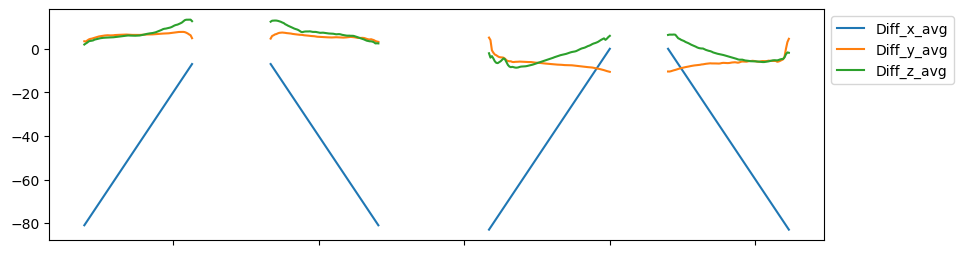

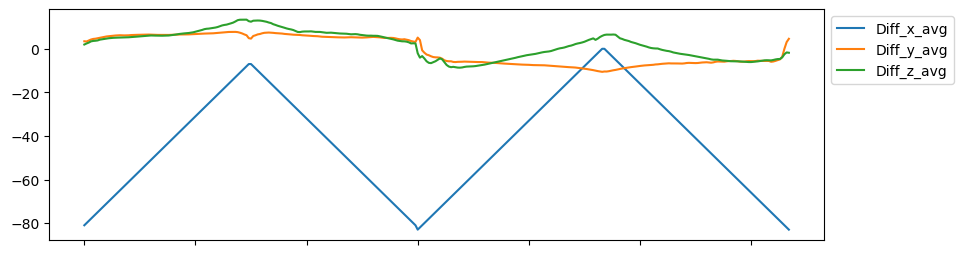

In [31]:
# Concatenate the averaged dataframes back into one dataframe
OKC_df = pd.concat([OKC_extension_avg_df, OKC_flexion_avg_df], ignore_index=True)
CKC_df = pd.concat([CKC_extension_avg_df, CKC_flexion_avg_df], ignore_index=True)
OKC_CKC_df = pd.concat([OKC_df, CKC_df], ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(OKC_CKC_df['Diff_x_avg'], label='Diff_x_avg')
ax.plot(OKC_CKC_df['Diff_y_avg'], label='Diff_y_avg')
ax.plot(OKC_CKC_df['Diff_z_avg'], label='Diff_z_avg')
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

OKC_CKC_dropped = OKC_CKC_df.dropna()

row_numbers = np.arange(len(OKC_CKC_dropped))  # Generate an array of row numbers
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(row_numbers, OKC_CKC_dropped['Diff_x_avg'], label='Diff_x_avg')
ax.plot(row_numbers, OKC_CKC_dropped['Diff_y_avg'], label='Diff_y_avg')
ax.plot(row_numbers, OKC_CKC_dropped['Diff_z_avg'], label='Diff_z_avg')
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

**Plot individual sensors and calculated differences between Sensor 1 and Sensor 2 (Diff_inv is not calibrated)**

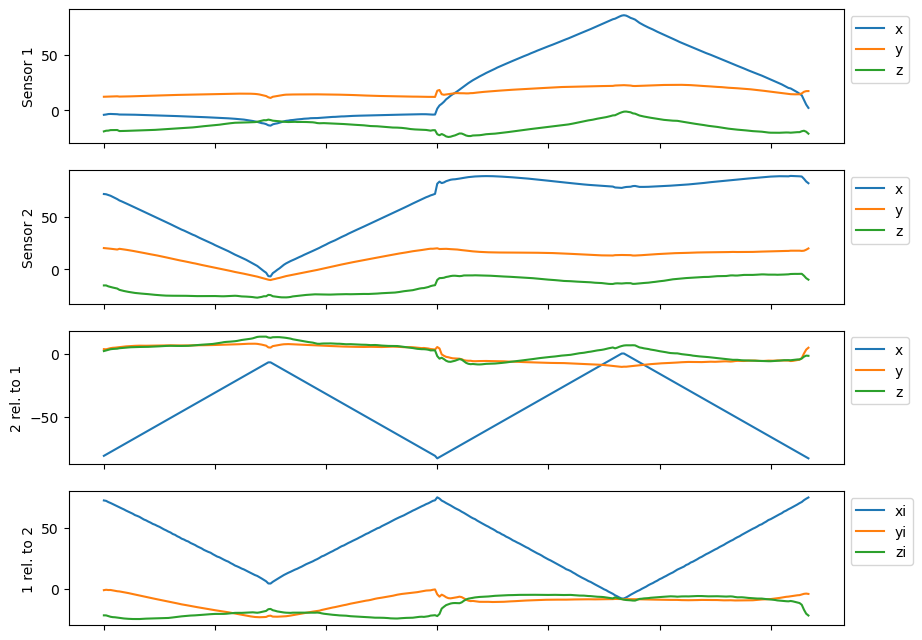

In [32]:
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(411)
ax1.plot(row_numbers, OKC_CKC_dropped['Sensor1_x_avg'])
ax1.plot(row_numbers,OKC_CKC_dropped['Sensor1_y_avg'])
ax1.plot(row_numbers,OKC_CKC_dropped['Sensor1_z_avg'])
ax1.legend(['x', 'y', 'z'], bbox_to_anchor=(1, 1), loc='upper left')
ax1.set_ylabel('Sensor 1')

ax2 = fig.add_subplot(412)
ax2.plot(row_numbers ,OKC_CKC_dropped['Sensor2_x_avg'])
ax2.plot(row_numbers ,OKC_CKC_dropped['Sensor2_y_avg'])
ax2.plot(row_numbers ,OKC_CKC_dropped['Sensor2_z_avg'])
ax2.legend(['x', 'y', 'z'], bbox_to_anchor=(1, 1), loc='upper left')
ax2.set_ylabel('Sensor 2')

ax3 = fig.add_subplot(413)
ax3.plot(row_numbers,OKC_CKC_dropped['Diff_x_avg'])
ax3.plot(row_numbers,OKC_CKC_dropped['Diff_y_avg'])
ax3.plot(row_numbers,OKC_CKC_dropped['Diff_z_avg'])
ax3.legend(['x', 'y', 'z'], bbox_to_anchor=(1, 1), loc='upper left')
ax3.set_ylabel('2 rel. to 1')

ax4 = fig.add_subplot(414)
ax4.plot(row_numbers,OKC_CKC_dropped['Diff_inv_x_avg'])
ax4.plot(row_numbers,OKC_CKC_dropped['Diff_inv_y_avg'])
ax4.plot(row_numbers,OKC_CKC_dropped['Diff_inv_z_avg'])
ax4.legend(['xi', 'yi', 'zi'], bbox_to_anchor=(1, 1), loc='upper left')
ax4.set_ylabel('1 rel. to 2')

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])


plt.show()

**Write Data to output folder**

In [33]:
# Write OKC_CKC_df to a new csv file with the name of the original filename appended with "_analysis" in the Output folder
output_dir = 'Output/'
output_filename = name.split('.')[0] + '_analysis.csv'
OKC_CKC_df.to_csv(os.path.join(output_dir, output_filename), index=False)

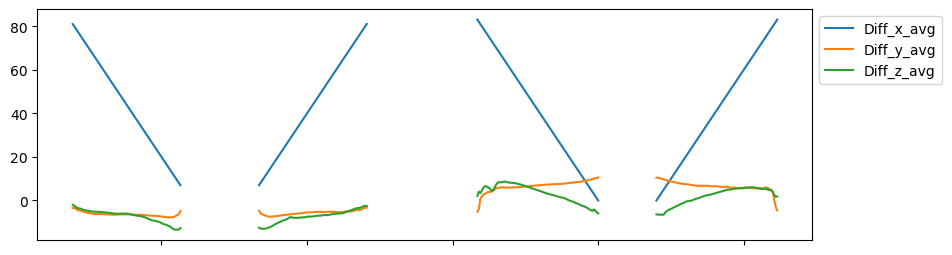

In [34]:
OKC_CKC_df_negated = -OKC_CKC_df.copy()

# plot OKC_CKC_df_negated
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(OKC_CKC_df_negated['Diff_x_avg'], label='Diff_x_avg')
ax.plot(OKC_CKC_df_negated['Diff_y_avg'], label='Diff_y_avg')
ax.plot(OKC_CKC_df_negated['Diff_z_avg'], label='Diff_z_avg')
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()




**Find baseline for the flexion position**

In [35]:
# Write OKC_CKC_df_negated to a new csv file with the name of the original filename appended with "_analysis_negated" in the Output folder
output_filename_negated = name.split('.')[0] + '_analysis_negated.csv'
OKC_CKC_df_negated.to_csv(os.path.join(output_dir, output_filename_negated), index=False)


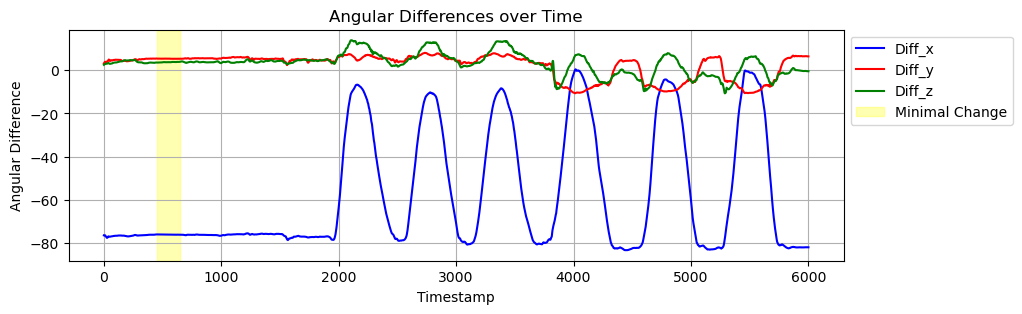

In [36]:
# Set the window size
window_size = 200

# Calculate the rolling standard deviation for each column
# rolling_std_x = baseline['Diff_x'].rolling(window=window_size).std()
rolling_std_y = flexion_baseline['Diff_y'].rolling(window=window_size).std()
rolling_std_z = flexion_baseline['Diff_z'].rolling(window=window_size).std()

# Find the intersection of minimal change sections
# minimal_change_section = (rolling_std_x + rolling_std_y + rolling_std_z).idxmin()
minimal_change_section = (rolling_std_y + rolling_std_z).idxmin()
# Extract the section
minimal_change_window_x = flexion_baseline.loc[minimal_change_section - window_size + 1:minimal_change_section]

# Plotting baseline['Diff_x'], baseline['Diff_y'], and baseline['Diff_z'] along with the section with minimal change

plt.figure(figsize=(10, 3))

# Plotting baseline['Diff_x']
plt.plot(flexion_baseline['timestamp'], flexion_baseline['Diff_x'], color='blue', label='Diff_x')

# Plotting baseline['Diff_y']
plt.plot(flexion_baseline['timestamp'], flexion_baseline['Diff_y'], color='red', label='Diff_y')

# Plotting baseline['Diff_z']
plt.plot(flexion_baseline['timestamp'], flexion_baseline['Diff_z'], color='green', label='Diff_z')

# Highlighting the section with minimal change
plt.axvspan(minimal_change_window_x['timestamp'].iloc[0], minimal_change_window_x['timestamp'].iloc[-1], color='yellow', alpha=0.3, label='Minimal Change')

plt.title('Angular Differences over Time')
plt.xlabel('Timestamp')
plt.ylabel('Angular Difference')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()




# # plot baseline 'Diff_x', 'Diff_y', 'Diff_z'
# plt.figure()
# baseline['Diff_x'].plot()
# baseline['Diff_y'].plot()
# baseline['Diff_z'].plot()

# plt.legend()
# plt.title('Angular difference')
# plt.show()